# LANL Notebook

Link to competition and dataset: https://www.kaggle.com/c/LANL-Earthquake-Prediction

Anaysis: https://www.kaggle.com/jsaguiar/seismic-data-exploration


## The Dataset
The training dataset has 2 columns (x, y), representing a single, continuous seismic signal.  x is the signal value, and y is the time-to-next-earthquake. The test data consists of segments of seismic signals (x values), and for each signal point in a segment, a time-to-next-earthquake (y) must be predicted by a machine learning model.

The dataset is large with over 600 million data points in the training signal (9 GB in csv format) and working with it will prove to be challenging (loading, visualizing, training models etc.).


## Useful Ideas

1. Downsampling to reduce dataset size:
> There are ways to do this without aliasing error (or minimal aliasing error). See the [Wiki article](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (short).


2. Noise filtering and other signal enhancements:
> The signal *may* be noisy. Any good filters (especially those used in the seismic domain) will improve our model accuracy.


3. Feature engineering: the raw signal maybe 'too raw' for the RNN to learn useful/ predictive patterns. We may have to engineer features.

    3.1. Feature detecting filters
> Features in signals are usually detected by filters (a filter is defined by its kernel: the impulse response). There may be feature detecting filters already used in the seismic analysis domain. Eg: filters to detect the presence of a peak.

    3.2. Engineering other features
> We can engineering other features such as: does_peak_exist_in_this_window, time_since_last_peak, or other signals derived from the original such as first_derivative, second_derivative, Fourier transform (DFT) of the window, moving_average_smoothed, etc.
    
    3.3. Map data to higher dimension, e.g. using Kernels


4. Automating feature engineering via convolutional nets (CNN)
> CNNs essentially learn the kernels of filters as part of the neural network. We can have some CNN layers before the LSTM layers and see if that works.


5. I checked some of the test files and it seems that the peaks are absent. Hence, I stongly recommend completely eliminating the peaks before training the RNN. Peaks will be considered outliers.


6. On the side, we will briefly try a different model, at least to answer the question "Did you try any other models?"

In [1]:
# Imports for the script

import numpy as np
import pandas as pd
import time, os

import matplotlib.pyplot as plt
#%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# To visualize the RNN network
from keras.utils.vis_utils import plot_model
import pydot

import utility  # Contains various helper utility functions

Using TensorFlow backend.


In [5]:
# Hardware (GPU or CPU)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'   # Disable GPU as it appears to be slower than CPU (to enable GPU, comment out this line and restart the kernel)

device_name = tf.test.gpu_device_name()

if device_name:
    print('GPU device found: {}. Using GPU'.format(device_name))
else:
    print("GPU device not found. Using CPU")
    #raise SystemError('GPU device not found')   # Stop the program if GPU is unavailabile: disabled for now

GPU device not found. Using CPU


In [6]:
# Variables that determines how the script behaves

# Data was convereted from CSV to HDF then truncated
hdf_key = 'my_key'

# Change the following to point to proper local paths
truncated_train_hdf_file = '../LANL-Earthquake-Prediction/truncated_train_hdf.h5' 
validation_hdf_file = '../LANL-Earthquake-Prediction/validation_hdf.h5'
test_hdf_file = '../LANL-Earthquake-Prediction/test_hdf.h5'

# Folder to save results
results_dir = 'results/current_run'

do_plot_series = False   # Whether training, validation, testing series should be plotted (time and memory consuming: keep this disabled unless necessary)

In [7]:
# Tunable parameters relating to the operation of the algorithm

# Data preprocessing
scaling_type = 'None'   # Supports: None, StandardScaler, MinMaxScaler

# LSTM network architecture
time_steps = 50
rnn_layer_units = [10, 5, 2]   # The length of this list = no. of hidden layers
rnn_layer_dropout_rate = [0.2, 0.2, 0]   # Dropout rate for each layer (0 for no dropout)

# Training
epochs = 2
batch_size = 64

# Some checks to ensure the parameters are valid
assert len(rnn_layer_units) == len(rnn_layer_dropout_rate)

## Import truncated Data from hdf files
### 3 sets: train, validation, test. Print basic stats about them and plot them

In [8]:
train_df = utility.read_hdf(truncated_train_hdf_file, hdf_key)
valid_df = utility.read_hdf(validation_hdf_file, hdf_key)
test_df = utility.read_hdf(test_hdf_file, hdf_key)

Reading HDF dataset ../LANL-Earthquake-Prediction/truncated_train_hdf.h5
Reading complete. time_to_read=5.97 seconds
Reading HDF dataset ../LANL-Earthquake-Prediction/validation_hdf.h5
Reading complete. time_to_read=3.27 seconds
Reading HDF dataset ../LANL-Earthquake-Prediction/test_hdf.h5
Reading complete. time_to_read=1.13 seconds


In [9]:
utility.print_info(train_df)

if do_plot_series:
    utility.plot_series(train_df, "Training series", results_dir) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (139000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139000000 entries, 0 to 138999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 2.3 GB
   acoustic_data  time_to_failure
0             12     1.4690999832
1              6     1.4690999821
2              8     1.4690999810
3              5     1.4690999799
4              8     1.4690999788


In [10]:
utility.print_info(valid_df)

if do_plot_series:
    utility.plot_series(valid_df, "Validation series", results_dir) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (80000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000000 entries, 139000000 to 218999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 1.3 GB
           acoustic_data     time_to_failure
139000000              5  12.635497500000001
139000001              3  12.635497499000001
139000002              5  12.635497497999999
139000003             -2  12.635497497000001
139000004              0  12.635497495999999


In [11]:
utility.print_info(test_df)

if do_plot_series:
    utility.plot_series(test_df, "Testing series", results_dir) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (27000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000000 entries, 219000000 to 245999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 463.5 MB
           acoustic_data    time_to_failure
219000000              1  6.969696360400000
219000001             -1  6.969696359299999
219000002              0  6.969696358200000
219000003              3  6.969696357100000
219000004              6  6.969696356000000


# Understanding Data

## Domain Perspective

https://www.youtube.com/watch?v=T0AEtX-uPLA
- Earthquakes occur when two parts of the earth suddenly move in relation to each other
- Earthequake originates at a point in earth called focus and spreads up to the surface at a point called Epicenter.
- A seismograph detects and records seismic waves. \n",
- Types of Seismic waves include:  Pressure (or Primary) Waves (P-Waves), Shear (or Secondary) Waves (S-Waves) and Surface Waves. P-Waves and S-Waves are both Body waves.

https://courses.lumenlearning.com/geophysical/chapter/earthquake-prediction/
- Predciting when an earthquake will occur is more difficult than predicting where it will occur.
- Sometimes (not always) earthquakes occur few seconds to few weeks after foreshocks.

https://en.wikipedia.org/wiki/P-wave
- P-Wave travel faster and hence are the first waves to reach sesimograph. They propagate through gases, liguids or solids. \n",
- S-Waves are attenuated by liquids.\n",
- P-Waves are non-destructive, while both S-Waves and Surfcae Waves are destructive. \n",
- Earthquake warning is possible if P-Waves are detected. Advanced warning time is dependent on the delay beween the arrival of P-wave and the arrival of the first destructive waves. This delay is a function of how deep the focus is, nature of earth layers and others. It ranges from few seconds to 90 seconds. Ground vibrations resulting from truck movement and contruction activitoes on earth shall be rejected for accurate detection of P-waves.

https://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/

## Statistical Perspective

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

We need to test data for random-walk/stochasiticity, e.g. correlation tests on both signal (f) and (df), covariance test?!



In [12]:
train_df.max()

acoustic_data      5444.000000000000000
time_to_failure      14.180599989999999
dtype: float64

In [13]:
train_df.min()

acoustic_data     -4621.00000000000000
time_to_failure       0.00069548217471
dtype: float64

# Recurrent Neural Network - LSTM

## Part 1 - Data Preprocessing

Training will be performed on downsampled dataset which consists of  3475  examples out of the original number of training examples which is  139000000
Plotting series
Plot saved to: results/current_run/Downsampled training series.png
Plotting complete. time_to_plot=0.24 seconds


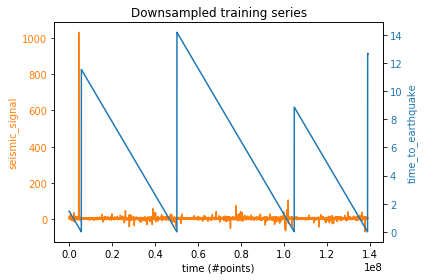

In [14]:
# Importing the training set
"""Temporary: we downsample the training datatset to reduce time!"""
down_sample=40000
dataset_train = train_df.iloc[::down_sample,:]
training_set = dataset_train.iloc[:, 0:2].values
print("Training will be performed on downsampled dataset which consists of ",dataset_train.shape[0],
      " examples out of the original number of training examples which is ", train_df.shape[0])

utility.plot_series(dataset_train, "Downsampled training series", results_dir)

In [15]:
dataset_train.info()
dataset_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475 entries, 0 to 138960000
Data columns (total 2 columns):
acoustic_data      3475 non-null int16
time_to_failure    3475 non-null float64
dtypes: float64(1), int16(1)
memory usage: 61.1 KB


,acoustic_data,time_to_failure
0,12,1.4690999832
40000,8,1.4595965336
80000,-1,1.4488975896
120000,4,1.4382986456
160000,9,1.4275997016


In [16]:
# Feature Scaling
print('Scaling the training set. scaling_type={}'.format(scaling_type))
t0 = time.time()
    
if scaling_type == 'None':
    training_set_scaled = training_set
else:
    if scaling_type == 'MinMaxScaler':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaling_type == 'StandardScaler':
        scaler = StandardScaler()
    
    signal_scaled = scaler.fit_transform(training_set[:,0].reshape(-1,1))

    training_set_scaled = training_set.copy()   # May not be necessary
    training_set_scaled[:,0] = signal_scaled.reshape(-1)

print('Scaling complete. time_to_scale={:.2f} seconds'.format(time.time() - t0))

Scaling the training set. scaling_type=None
Scaling complete. time_to_scale=0.00 seconds


In [17]:
# Creating the training dataset (X_train and y_train) 
# X_train is a numpy array with some no. of examples. Each example is a seismic signal window of length time_steps
# y_train has the same no. of examples. Each example is the time_to_eq value that corresponds to the last element of seismic signal window (just 1 value)

# ToDo:
# Draw a diagram here illustrating how this input is prepared.
# Write an equation for no. of examples as a function of (training_signal_length, time_steps, stride)

print('Preparing input to the RNN (training set)')
t0 = time.time()

X_train = []
y_train = []
    
for i in range (time_steps, training_set_scaled.shape[0]): 
    X_train.append (training_set_scaled[i - time_steps:i, 0])
    y_train.append (training_set_scaled[i, 1])
X_train, y_train = np.array (X_train), np.array (y_train)

# Reshaping since RNN accepts 3d input
X_train = np.reshape (X_train, (X_train.shape[0], X_train.shape[1], 1))
print ("The 3d shape necessary for RNN's input is ", X_train.shape, " . Note how the number of examples is reduced by the defined time steps, i.e. ", time_steps)

assert X_train.shape[1] == time_steps

print('Preparing input complete. time_to_prepare={:.2f} seconds'.format(time.time() - t0))

Preparing input to the RNN (training set)
The 3d shape necessary for RNN's input is  (3425, 50, 1)  . Note how the number of examples is reduced by the defined time steps, i.e.  50
Preparing input complete. time_to_prepare=0.01 seconds


In [18]:
#Check
#print(training_set_scaled[99,0], " ", training_set_scaled[100,1])  # Gives errors when time_steps != 100 (fix this bug)
#print(X_train[0,99,0]," ", y_train[0])

## Part 2 - Building the RNN

In [19]:
# Initialising the RNN
regressor = Sequential ()

# Adding the hidden layers as given in the parameters

for i, (units, dropout_rate) in enumerate(zip(rnn_layer_units, rnn_layer_dropout_rate)):
    # Common args for all layers
    input_shape = (None,)
    return_sequences = True
    
    # Set special args for first and last layer
    if i == 0:  # First hidden layer
        input_shape = (time_steps, 1)
    if i == len(rnn_layer_units) - 1:   # Last hidden layer
        return_sequences = False
        
    regressor.add(LSTM(units=units, return_sequences=return_sequences, input_shape=input_shape))
    regressor.add (Dropout(dropout_rate))

# Adding the output layer
regressor.add (Dense (units=1))

# Compiling the RNN
regressor.compile (optimizer='adam', loss='mean_squared_error')
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 10)            480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 10)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 5)             320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 5)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 64        
_________________________________________________________________
dropout_3 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total para

## Part 3 - Training the RNN

In [20]:
print('Training the RNN with the training set')
t0 = time.time()

#with tf.device('/cpu:0'):

history = regressor.fit (X_train, y_train, epochs=epochs, batch_size=batch_size)

time_to_train = time.time() - t0
print('Training complete. time_to_train={:.2f} seconds ({:.2f} minutes)'.format(time_to_train, time_to_train/60))

Training the RNN with the training set
Epoch 1/2
3425/3425 [==============================] - 3s 943us/step - loss: 44.8566
Epoch 2/2
3425/3425 [==============================] - 2s 549us/step - loss: 40.5613
Training complete. time_to_train=7.16 seconds (0.12 minutes)


In [21]:
# Save the final trained model (in case we need to continue training from this point on)

model_filepath = results_dir + '/final_model.h5'
regressor.save(model_filepath, overwrite=True)

print('RNN model saved to {}'.format(model_filepath))

RNN model saved to results/current_run/final_model.h5


Plot saved to: results/current_run/training_history.png
RNN plot saved to results/current_run/rnn_plot.png


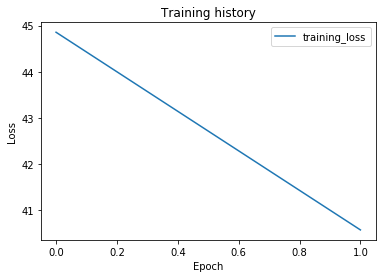

In [22]:
utility.plot_training_history(history, results_dir)

model_plot_filename = results_dir + '/' + 'rnn_plot.png'
plot_model(regressor, to_file=model_plot_filename, show_shapes=True, show_layer_names=True)

print('RNN plot saved to {}'.format(model_plot_filename))

## Part 4 - Making the predictions and visualising the results

In [23]:
# Import validation set
"""Temporary: we downsample the testing datatset to reduce time!"""
dataset_test = valid_df.iloc[::down_sample,:]
true_test_time = dataset_test.iloc[:,1].values
print("Validation will be performed on truncated dataset which consists of ",dataset_test.shape[0],
      " examples out of the original number of training examples which is ", valid_df.shape[0])

Validation will be performed on truncated dataset which consists of  2000  examples out of the original number of training examples which is  80000000


In [24]:
dataset_test.info()
dataset_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 139000000 to 218960000
Data columns (total 2 columns):
acoustic_data      2000 non-null int16
time_to_failure    2000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 35.2 KB


,acoustic_data,time_to_failure
139000000,5,12.635497500000001
139040000,10,12.624898556000000
139080000,4,12.614199612000000
139120000,8,12.604696163000000
139160000,7,12.593997219000000


In [25]:
#Because we have time_steps time steps and we we want to predict the first entry of time_to_failure in the validation set, we have to look back time_steps samples. 
#Hence, we get these time_steps past samples from the training set. This is why we first concatenate both training and validation. This step may be omitted if we just need to predict one value
#for the whole test set (such as in the provided test files where one value is only needed so we can look back in the same data provided ) 
dataset_total = pd.concat((dataset_train['acoustic_data'], dataset_test['acoustic_data']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values
inputs = inputs.reshape(-1,1)

# Feature Scaling
if scaling_type == 'None':
    inputs_scaled=inputs
else:
    print('Scaling the inputs set. scaling_type={}'.format(scaling_type))
    t0 = time.time()
    inputs_scaled = scaler.transform(inputs) 
    print('Scaling complete. time_to_scale={:.2f} seconds'.format(time.time() - t0))

inputs_scaled.shape # So we end up with input size = size of validation set + time_steps

(2050, 1)

In [26]:
X_test = []

for i in range(time_steps, inputs_scaled.shape[0]):
    X_test.append(inputs_scaled[i-time_steps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(2000, 50, 1)

In [27]:
# Predict on training set

print('Predicting on the training set using the trained RNN')
t0 = time.time()
train_predicted_time = regressor.predict(X_train)
#predicted_time = sc.inverse_transform(predicted_time)
print('Predicting on the training set complete. time_to_predict={:.2f} seconds'.format(time.time() - t0))

Predicting on the training set using the trained RNN
Predicting on the training set complete. time_to_predict=0.81 seconds


In [28]:
# Save predictions on training set

train_prediction = pd.DataFrame(train_predicted_time)
train_pred_filename = results_dir + '/' + 'train_prediction.csv'
train_prediction.to_csv(train_pred_filename)
print('Predictions on train set saved to {}'.format(train_pred_filename))

Predictions on train set saved to results/current_run/train_prediction.csv


Predictions plot saved to: results/current_run/train_true_vs_pred.png


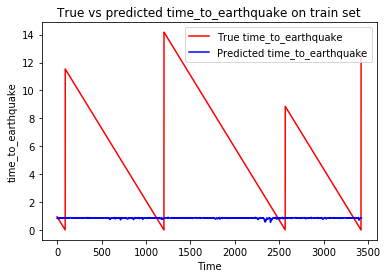

In [29]:
# Visualize predictions on training set

true_train_time = dataset_train.iloc[:,1].values
true_train_time = true_train_time[time_steps:]   # Ignore the first time_steps values (because predictions are not available for those)

train_res_plot_filename = results_dir + '/' + 'train_true_vs_pred' + '.png'
utility.plot_results(true_train_time, train_prediction, 'True vs predicted time_to_earthquake on train set', train_res_plot_filename)

In [30]:
# Compute error metrics on training set

train_mse = mean_squared_error(true_train_time, train_predicted_time)
train_rmse = train_mse ** 0.5
train_mae = mean_absolute_error(true_train_time, train_predicted_time)

print('Error metrics on test set. train_mse: {:.4f}, train_rmse: {:.4f}, train_mae: {:.4f}'.format(train_mse, train_rmse, train_mae))

Error metrics on test set. train_mse: 38.5610, train_rmse: 6.2097, train_mae: 5.0566


In [31]:
# Predict on test set

print('Predicting on the test set using the trained RNN')
t0 = time.time()
test_predicted_time = regressor.predict(X_test)
#predicted_time = sc.inverse_transform(predicted_time)
print('Predicting on the test set complete. time_to_predict={:.2f} seconds'.format(time.time() - t0))

Predicting on the test set using the trained RNN
Predicting on the test set complete. time_to_predict=0.38 seconds


In [32]:
# Save predictions on test set

test_prediction = pd.DataFrame(test_predicted_time)
test_pred_filename = results_dir + '/' + 'test_prediction.csv'
test_prediction.to_csv(test_pred_filename)
print('Predictions on test set saved to {}'.format(test_pred_filename))

Predictions on test set saved to results/current_run/test_prediction.csv


Predictions plot saved to: results/current_run/test_true_vs_pred.png


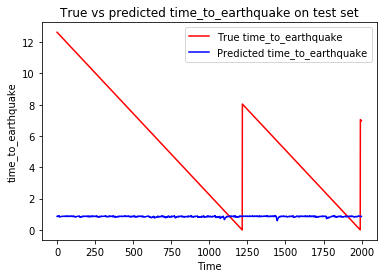

In [33]:
# Visualize predictions on test set

test_res_plot_filename = results_dir + '/' + 'test_true_vs_pred' + '.png'
utility.plot_results(true_test_time, test_prediction, 'True vs predicted time_to_earthquake on test set', test_res_plot_filename)

In [34]:
# Compute error metrics on test set

test_mse = mean_squared_error(true_test_time, test_predicted_time)
test_rmse = test_mse ** 0.5
test_mae = mean_absolute_error(true_test_time, test_predicted_time)

print('Error metrics on test set. test_mse: {:.4f}, test_rmse: {:.4f}, test_mae: {:.4f}'.format(test_mse, test_rmse, test_mae))

Error metrics on test set. test_mse: 32.3933, test_rmse: 5.6915, test_mae: 4.6511


In [35]:
# Save the output (results) of this notebook to the results_dir folder
%sx jupyter nbconvert --to html --output-dir=$results_dir --TemplateExporter.exclude_input=True LANL_NB.ipynb

['Traceback (most recent call last):',
 '  File "D:\\Anaconda3\\Scripts\\jupyter-nbconvert-script.py", line 6, in <module>',
 '    from nbconvert.nbconvertapp import main',
 '  File "D:\\Anaconda3\\lib\\site-packages\\nbconvert\\__init__.py", line 7, in <module>',
 '    from . import postprocessors',
 '  File "D:\\Anaconda3\\lib\\site-packages\\nbconvert\\postprocessors\\__init__.py", line 5, in <module>',
 '    from .serve import ServePostProcessor',
 '  File "D:\\Anaconda3\\lib\\site-packages\\nbconvert\\postprocessors\\serve.py", line 19, in <module>',
 '    class ProxyHandler(web.RequestHandler):',
 '  File "D:\\Anaconda3\\lib\\site-packages\\nbconvert\\postprocessors\\serve.py", line 21, in ProxyHandler',
 '    @web.asynchronous',
 "AttributeError: module 'tornado.web' has no attribute 'asynchronous'"]